# Load MNIST

In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

target_idx = np.where(mnist.train.labels<2)[0]
foreground = mnist.train.images[target_idx,:][:5000]
target_labels = mnist.train.labels[target_idx][:5000]

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### PCA on Regular MNIST

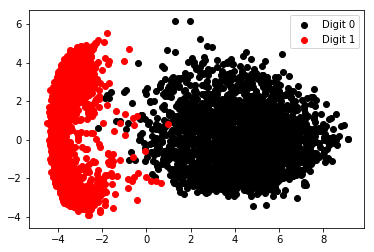

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fg = pca.fit_transform(foreground)
colors = ['k','r']

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1], 
                color=colors[i], label='Digit ' +str(l))
plt.legend()

# Load Natural Images of Grass

These pictures are found in this [OneDrive link](https://1drv.ms/f/s!AgLi37o1j88ahrJTLeycjuEoHpVhQw), or they can be downloaded from [ImageNet](http://image-net.org/download) using the synset 'grass'. (*Note*: replace IMAGE_PATH with path to the downloaded images)

In [3]:
from PIL import Image
from utils import resize_and_crop
import os

IMAGE_PATH = 'C:\\Users\\aabid\\OneDrive\\Pictures\\Imagenet-Grass\\' #Replace with your own path to downloaded images
        
natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
for filename in os.listdir(IMAGE_PATH):
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale
            im = resize_and_crop(im) #resize and crop each picture to be 100px by 100px
            natural_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
            
natural_images=np.asarray(natural_images,dtype=float)
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

Array of grass images: (895, 10000)


# Corrupt MNIST by Superimposing Images of Grass

To create each of the 5000 corrupted digits, randomly chosen a 28px by 28px region from a grass image to be superimposed on top of the digits.

In [4]:
np.random.seed(0) # for reproducibility

rand_indices =  np.random.permutation(natural_images.shape[0]) # just shuffles the indices
split = int(len(rand_indices)/2)
target_indices = rand_indices[0:split] # choose the first half of images to be superimposed on target
background_indices = rand_indices[split:] # choose the second half of images to be background dataset

target = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
    idx = np.random.choice(target_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    target[i] = 0.25*foreground[i] + superimposed_patch
    
    idx = np.random.choice(background_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    background[i] = background_patch

### Some Example Images

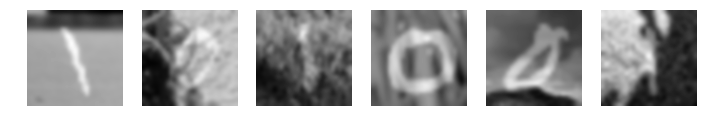

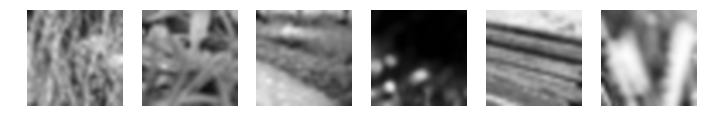

In [5]:
n_show=6

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(5000)
    plt.imshow(np.reshape(target[idx,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(5000)
    plt.imshow(np.reshape(background[idx,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')
    

### PCA on Corrupted MNIST

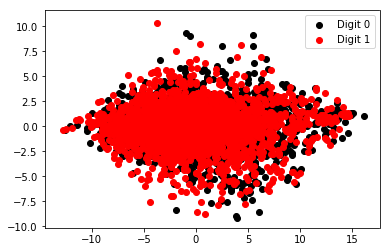

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fg = pca.fit_transform(target)

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1], 
                color=colors[i], label='Digit ' +str(l))
plt.legend()

# Perform Contrastive PCA

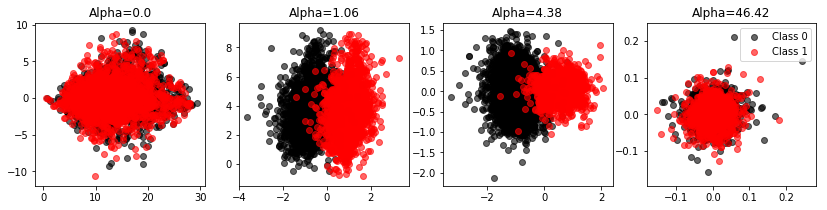

In [7]:
from contrastive import CPCA

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=target_labels)

# Features Captured by PCA vs. cPCA

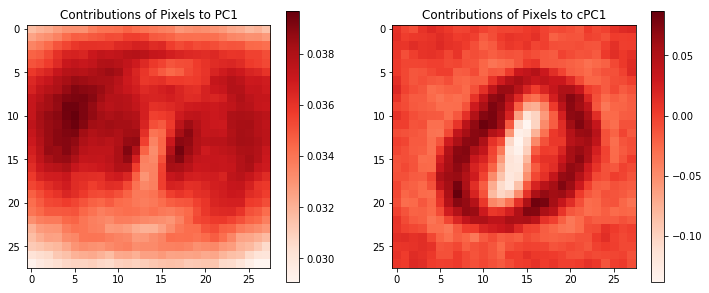

In [8]:
plt.figure(figsize=[12,5])
w, v = np.linalg.eig(mdl.fg_cov)
idx = np.argmax(w)
plt.subplot(1,2,1)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to PC1')

w, v = np.linalg.eig(mdl.fg_cov - 4.38*mdl.bg_cov) # the value 4.38 is taken from the previous diagram, where alpha=4.38 separates the clusters most clearly
idx = np.argmax(w)
plt.subplot(1,2,2)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to cPC1')

# Denoising with PCA vs. cPCA

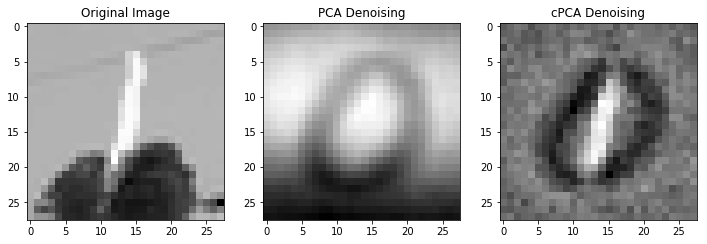

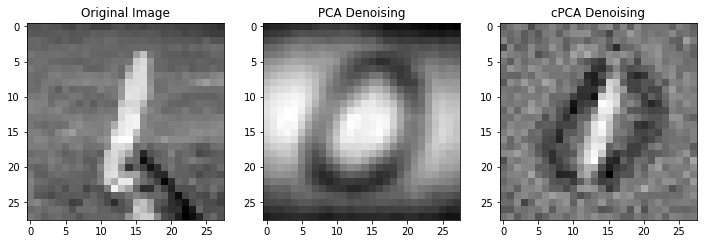

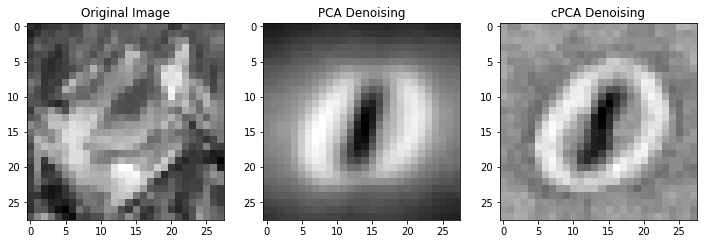

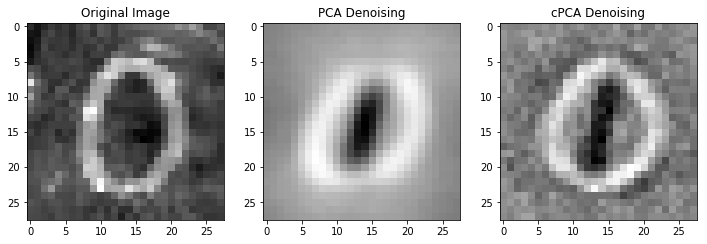

In [9]:
n_components = 5
for idx in range(4):
    image = target[idx:idx+1]
    plt.figure(figsize=[12,12])
    plt.subplot(1,3,1)
    plt.imshow(image.reshape(28,28),cmap='gray')
    plt.title('Original Image')

    w, v = np.linalg.eig(mdl.fg_cov)
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,2)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('PCA Denoising')

    w, v = np.linalg.eig(mdl.fg_cov - 4.38*mdl.bg_cov) # the value 4.38 is taken from the plot that is two plots previous to this one, where alpha=4.38 separates the clusters most clearly
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,3)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('cPCA Denoising')